<a href="https://colab.research.google.com/github/seanreed1111/BDA_py_demos/blob/master/pyro_count_regression_texting_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_Pyro.ipynb


In [ ]:
pip install pyro-ppl

     |████████████████████████████████| 713 kB 4.1 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

assert pyro.__version__.startswith('1.8.0')
pyro.set_rng_seed(1)
torch.manual_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 5]

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv", header=None)
df.columns = ['messages_received']
df.loc[:,'day'] = df.index +1
df.head()

,messages_received,day
0,13.0,1
1,24.0,2
2,8.0,3
3,24.0,4
4,7.0,5


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
messages_received,74.0,19.743243,14.141226,0.0,11.00,17.0,23.00,72.0
day,74.0,37.500000,21.505813,1.0,19.25,37.5,55.75,74.0


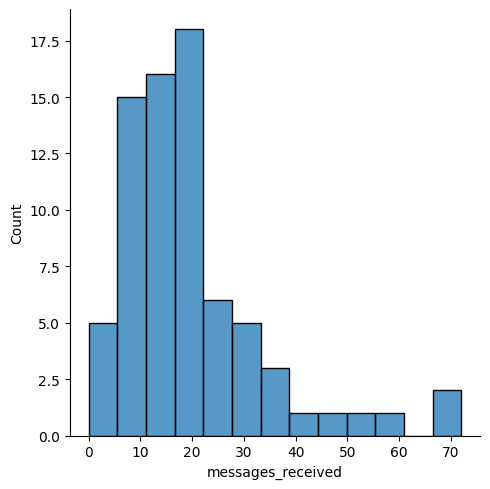

In [ ]:
sns.displot(x = df['messages_received']);

You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. How would you model this data

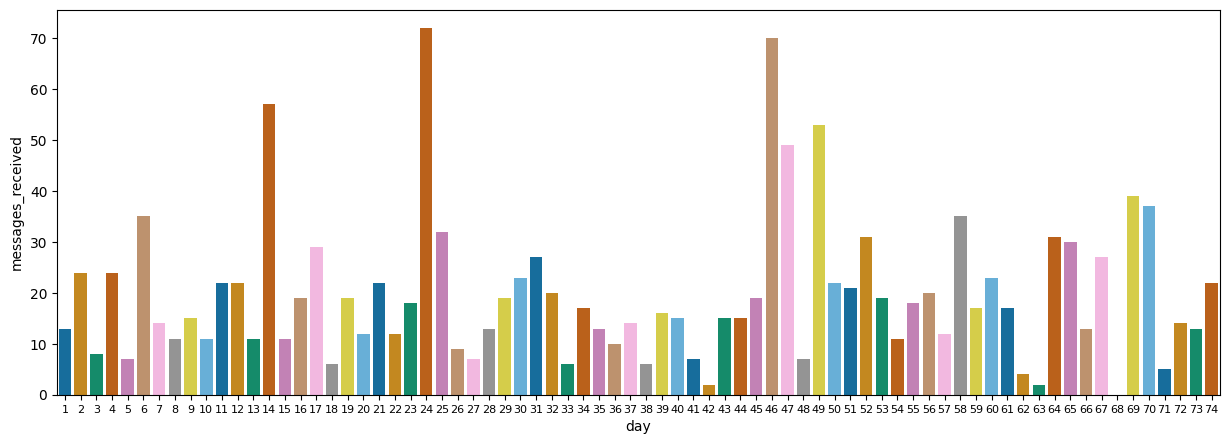

In [ ]:
sns.barplot(y='messages_received', x='day', data=df, palette='colorblind')
plt.xticks(fontsize=8);

Let's hypothesize that there is a switchpoint somewhere in the time series where the rate of texting increases. How can we find it with pyro?

In [ ]:
X = df.copy()

In [ ]:
X['messages_received'].mean(), X['messages_received'].std()

(19.743243243243242, 14.14122585879093)

In [ ]:
# Let's look at an actual poisson distribution fit to the mean of the data
samples = dist.Poisson(X['messages_received'].mean()).sample(tensor([74])) # create sample distribution where Poisson mean = data mean
sample_df = pd.DataFrame({'sample_texts_received':samples.numpy(), 'day':X['day'].copy()})

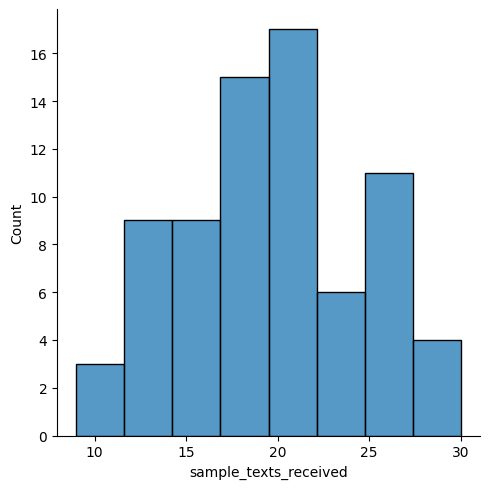

In [ ]:
sns.displot(x = sample_df['sample_texts_received']);

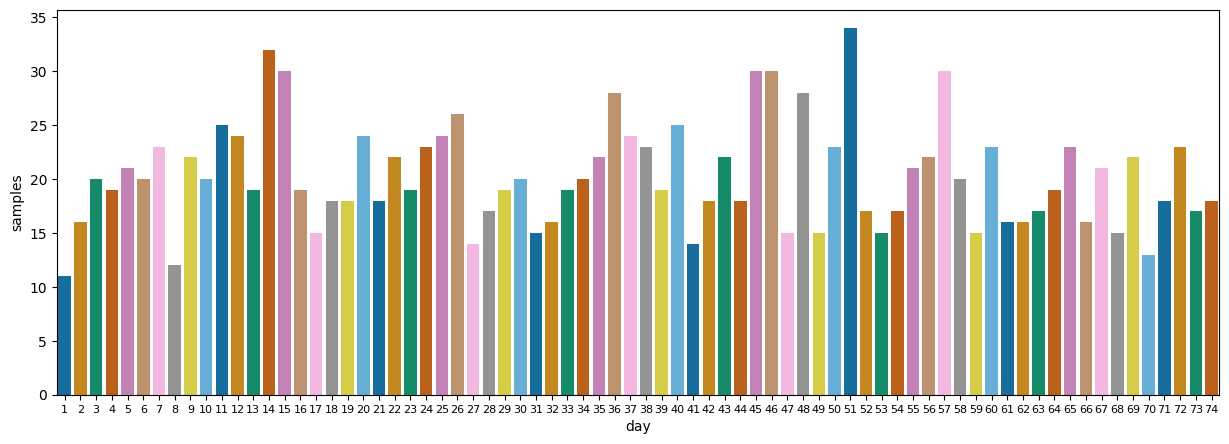

In [ ]:
sns.barplot(y='samples', x='day', data=sample_df, palette='colorblind');
plt.xticks(fontsize=8);

### So, comparing the actual data with the above two poisson sampling distributions above, it appears our data is overdispersed. Our data is heavily skewed to the right, ie., it has many more texts received far away from the mean, and much greater variability spikes much bigger than a poisson distribution would suggest.

### Despite the fact that we know the poisson is not the 'correct' distribution to handle the outliers here, let's continue with the analysis now, and we can try other distributions in future work

In [ ]:
data = tensor(X['messages_received'].values, dtype=torch.float)

In [ ]:
def model(data):
    alpha = 1.0 / data.mean()
    lambda_1 = pyro.sample("lambda_1", dist.Exponential(alpha))
    lambda_2 = pyro.sample("lambda_2", dist.Exponential(alpha))
    
    tau = pyro.sample("tau", dist.Uniform(0, 1))
    lambda1_size = (tau * data.size(0) + 1).long()
    lambda2_size = data.size(0) - lambda1_size
    lambda_ = torch.cat([lambda_1.expand((lambda1_size,)),
                         lambda_2.expand((lambda2_size,))])

    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Poisson(lambda_), obs=data)

In [ ]:
from pyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [ ]:
def train(model, guide, lr=0.01, n_steps=4000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")
    print(f"Final Elbo loss: {elbo}")

In [ ]:
%%time
train(model, guide)

Elbo loss: 502.6074719429016
Elbo loss: 498.8151116371155
Elbo loss: 497.65202021598816
Elbo loss: 496.98076605796814
Elbo loss: 497.57296097278595
Elbo loss: 499.85331213474274
Elbo loss: 498.7296109199524
Elbo loss: 494.610315322876
Final Elbo loss: 498.78914296627045
CPU times: user 23.6 s, sys: 23.6 ms, total: 23.6 s
Wall time: 23.8 s


In [ ]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if k != "obs"}

In [ ]:
svi_samples.keys()

dict_keys(['lambda_1', 'lambda_2', 'tau'])

In [ ]:
guide.quantiles([0.05,0.50,0.95])

{'lambda_1': tensor([18.1802, 19.3330, 20.5589]),
 'lambda_2': tensor([18.5888, 19.7519, 20.9878]),
 'tau': tensor([0.0522, 0.4893, 0.9434])}

Can see that SVI does not work in this instance, lambda_1 and lambda_2 overlap substantially.

In [ ]:
## Let's do MCMC instead

In [ ]:
kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=3)
posterior = MCMC(kernel, num_samples=5000, warmup_steps=500)
posterior.run(data);

Sample: 100%|██████████| 5500/5500 [00:57, 95.62it/s, step size=9.09e-02, acc. prob=0.859] 


In [ ]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}
lambda_1_samples = hmc_samples['lambda_1']
lambda_2_samples = hmc_samples['lambda_2']
tau_samples = (hmc_samples['tau'] * data.size(0) + 1).astype(int)

In [ ]:
data.size(0)

74

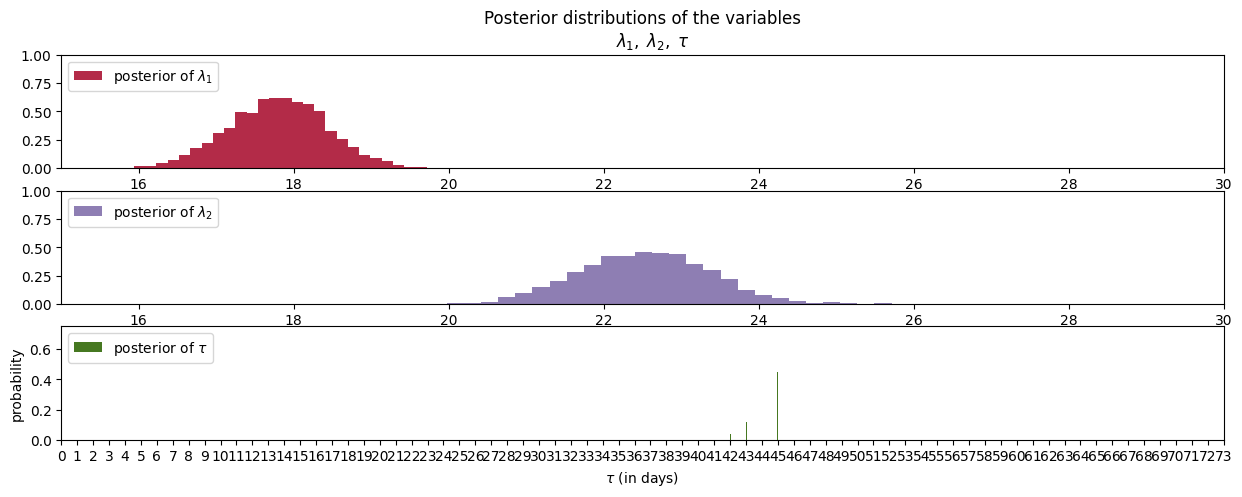

In [ ]:
# plt.figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=data.size(0), alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(data.size(0)))

plt.legend(loc="upper left")
plt.ylim([0, .75])
# plt.xlim([35, len(data.size(0))-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### Interpretation
Recall that Bayesian methodology returns a distribution. Hence we now have distributions to describe the unknown s and . What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: 
 is around 18 and 
 is around 23. The posterior distributions of the two s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

What other observations can you make? If you look at the original data again, do these results seem reasonable?

Notice also that the posterior distributions for the s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.

Our analysis also returned a distribution for . Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of  would have been more spread out, reflecting that many days were plausible candidates for . By contrast, in the actual results we see that only three or four days make any sense as potential transition points.

In [ ]:
# The switchpoint analysis done above would be considerably more difficult to do without Bayesian calculations